# blender implicit with search

## autoreload

In [1]:
%load_ext autoreload
%autoreload 2

## dir setup

In [2]:
from dotenv import load_dotenv, find_dotenv
import os

this_file_path = os.path.dirname(os.path.abspath("__file__"))
# if script (not notebook)...
# project_dir = os.path.join(os.path.dirname(__file__), os.pardir)

# project directory
project_dir = os.path.join(this_file_path, os.pardir)

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

True

In [3]:
raw_data_dir = os.path.join(project_dir, os.environ.get("RAW_DATA_DIR"))
processed_data_dir = os.path.join(project_dir, os.environ.get("PROCESSED_DATA_DIR"))
interim_data_dir = os.path.join(project_dir, os.environ.get("INTERIM_DATA_DIR"))
wordvecs_data_dir = os.path.join(project_dir, os.environ.get("WORDVECS_DATA_DIR"))
figures_dir = os.path.join(project_dir, os.environ.get("FIGURES_DIR"))
reports_dir = os.path.join(project_dir, os.environ.get("REPORTS_DIR"))
cv_dir = os.path.join(project_dir, os.environ.get("CV_DIR"))
models_dir = os.path.join(project_dir, os.environ.get("MODELS_DIR"))

In [4]:
TEST_OFFSET = int(os.environ.get("TEST_OFFSET"))
TOTAL_TEST_SEQS = int(os.environ.get("TOTAL_TEST_SEQS"))

## imports

In [5]:
import numpy as np
from datetime import datetime

In [6]:
import pandas as pd
# pd.set_option('max_rows', None)
# pd.set_option('max_columns', None)
# pd.options.mode.chained_assignment = None  # default='warn'

In [7]:
from tqdm import tqdm
tqdm.pandas()

/Users/hitoshinagano/.virtualenvs/tensorflow2/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [8]:
# import scipy.sparse as sparse
# import implicit

# from sklearn.metrics import ndcg_score

# from sklearn.model_selection import ParameterGrid

# import mlflow

import pickle

## project imports

In [9]:
import sys
sys.path.insert(0, '..')

In [10]:
from src.features import *
from src.models import *

# pred 6
#### reading pred 6 (implicit preds)

In [11]:
pred_6_fn = 'pred_6_with_topscore.csv'
pred_6_fp = os.path.join(reports_dir, pred_6_fn)
pred_6 = pd.read_csv(pred_6_fp, header = None)

In [12]:
pred_6.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1572239,1194894,1717880,1300048,1006988,341077,398330,1856280,1326593,794338,0.923182
1,943786,849692,1676401,1056120,416551,937449,1180937,80018,495680,1184491,0.980219
2,731397,1986443,1706245,167018,283306,722653,438010,2015578,1162105,1322369,0.361114
3,1398419,1465133,1114720,1983750,702406,19910,1784740,63682,8478,819461,0.406496
4,1950320,1412311,553430,758537,1683191,1094798,769817,236682,6328,74407,0.944184


In [13]:
pred_6 = pred_6.reindex(index = range(TOTAL_TEST_SEQS))

<AxesSubplot:>

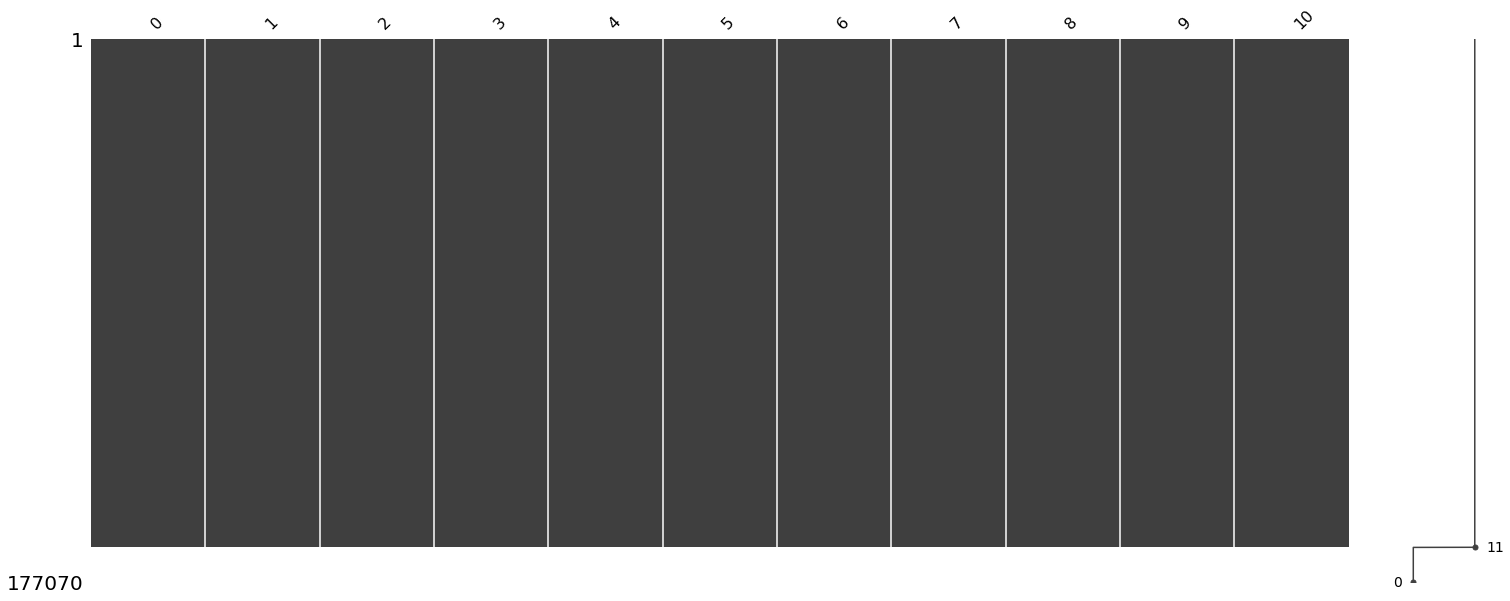

In [14]:
import missingno as mn
mn.matrix(pred_6)

### using actual submitted csv
pred_6_with_topscore.csv is missing rows...

In [15]:
pred_6_fn = 'pred_6_implicit.csv'
pred_6_fp = os.path.join(reports_dir, pred_6_fn)
pred_6_submitted = pd.read_csv(pred_6_fp, header = None)

In [16]:
pred_6_submitted[pred_6_submitted.duplicated(keep = False)]

,0,1,2,3,4,5,6,7,8,9
3,1587422,1803710,10243,548905,1906937,716822,1361154,1716388,859574,725371
7,1587422,1803710,10243,548905,1906937,716822,1361154,1716388,859574,725371
14,1587422,1803710,10243,548905,1906937,716822,1361154,1716388,859574,725371
16,23903,624249,602671,1076204,1805356,1251230,1656985,184980,2022473,344295
26,2072175,1102234,1362211,485245,1450809,2100037,2076362,1294434,1363977,531471
...,...,...,...,...,...,...,...,...,...,...
177039,23903,624249,602671,1076204,1251230,1805356,184980,1656985,2022473,344295
177045,1030770,646288,211927,1022423,1577307,1452260,372639,1580759,1433118,1315888
177054,356153,1554936,804903,389388,645773,527577,701247,1268709,1551100,462003
177058,1587422,1803710,10243,548905,1906937,716822,1361154,1716388,859574,725371


In [17]:
pred_6_submitted['no_implicit_pred'] = (pred_6_submitted[0] == 1587422) & (pred_6_submitted[1] == 1803710) & (pred_6_submitted[9] == 725371)

pred_6_submitted = pred_6_submitted[~pred_6_submitted.no_implicit_pred].copy()

pred_6_submitted.drop('no_implicit_pred', axis = 1, inplace = True)

In [18]:
# pred_6 = pred_6.reindex(index = range(TOTAL_TEST_SEQS))

In [19]:
pred_6_submitted

,0,1,2,3,4,5,6,7,8,9
0,1572239,1194894,1717880,1300048,1006988,341077,398330,1856280,1326593,794338
1,943786,849692,1676401,1056120,416551,937449,1180937,80018,495680,1184491
2,731397,1986443,1706245,167018,283306,722653,438010,2015578,1162105,1322369
4,1398419,1465133,1114720,1983750,702406,19910,1784740,63682,8478,819461
5,1950320,1412311,553430,758537,1683191,1094798,769817,236682,6328,74407
...,...,...,...,...,...,...,...,...,...,...
177065,23903,624249,602671,1076204,1805356,1251230,1656985,184980,2022473,763171
177066,69447,716822,1328443,161963,1651522,1328997,780726,717106,1859462,459697
177067,1550304,1426798,273237,1395589,2033823,460028,1839331,1576126,289602,136713
177068,1116998,1197876,517435,1396359,273725,1803169,662857,1575734,1565340,745928


# pred 7
## preparing pred_7

In [19]:
pt_search_recs_fn = 'pt_search_recs.pkl'
pt_search_recs_fp = os.path.join(interim_data_dir, pt_search_recs_fn)
pt_search_recs = pd.read_pickle(pt_search_recs_fp)

# es_search_recs_fn = 'es_search_recs.pkl'
# es_search_recs_fp = os.path.join(interim_data_dir, es_search_recs_fn)
# es_search_recs = pd.read_pickle(es_search_recs_fp)

In [20]:
pt_search_recs = pt_search_recs.applymap(lambda x: x[0]).T
# es_search_recs = es_search_recs.applymap(lambda x: x[0]).T

In [21]:
# search_recs = pd.concat([pt_search_recs, es_search_recs])
search_recs = pt_search_recs

In [22]:
search_recs.sort_index(inplace = True)

In [23]:
search_recs

,0,1,2,3,4,5,6,7,8,9
3,814644,1892910,1929037,337033,976976,1495252,541684,448188,816584,1380283
7,1082150,1383352,228294,280001,905962,906435,520318,830606,1501646,63665
14,1851419,148757,1220316,1182308,1274709,511711,311980,2029715,635704,1005775
90,109814,1169893,218698,1885984,1540766,512315,916762,502870,84712,1726133
98,1429023,655663,174389,1589919,1147203,1332181,1231500,1760346,1313508,1476421
...,...,...,...,...,...,...,...,...,...,...
177022,829923,1793967,485717,1692963,760768,1685125,1030062,1487578,1311781,925639
177024,131921,90072,423989,791587,1042837,736983,1816259,1603854,630862,1478801
177028,34681,1638469,1313392,154859,656288,371714,1230747,774374,547697,763433
177037,245362,1541195,260797,852531,1473056,195149,2045233,1624469,634569,1091661


In [24]:
replaced_idx = list(set(search_recs.index) & set(pred_6_submitted.index))

In [25]:
len(replaced_idx)

0

### merging both prediction dataframes - dropping from implicit if duplicated

In [26]:
pred_7 = pd.concat([search_recs, pred_6_submitted])

In [29]:
pred_7.sort_index(inplace = True)

In [30]:
pred_7

,0,1,2,3,4,5,6,7,8,9
0,1572239,1194894,1717880,1300048,1006988,341077,398330,1856280,1326593,794338
1,943786,849692,1676401,1056120,416551,937449,1180937,80018,495680,1184491
2,731397,1986443,1706245,167018,283306,722653,438010,2015578,1162105,1322369
3,814644,1892910,1929037,337033,976976,1495252,541684,448188,816584,1380283
4,1398419,1465133,1114720,1983750,702406,19910,1784740,63682,8478,819461
...,...,...,...,...,...,...,...,...,...,...
177065,23903,624249,602671,1076204,1805356,1251230,1656985,184980,2022473,763171
177066,69447,716822,1328443,161963,1651522,1328997,780726,717106,1859462,459697
177067,1550304,1426798,273237,1395589,2033823,460028,1839331,1576126,289602,136713
177068,1116998,1197876,517435,1396359,273725,1803169,662857,1575734,1565340,745928


In [32]:
pred_7_fn = 'pred_7_implicit_search_embs_noviews.csv'
pred_7_fp = os.path.join(reports_dir, pred_7_fn)
pred_7.to_csv(pred_7_fp, header = None, index = None)

# pred 8
## preparing pred_8

In [42]:
pt_search_recs_fn = 'zero_views_low_ndcg_preds_for_pred_8_pt.pkl'
pt_search_recs_fp = os.path.join(reports_dir, pt_search_recs_fn)
pt_search_recs = pd.read_pickle(pt_search_recs_fp)

es_search_recs_fn = 'zero_views_low_ndcg_preds_for_pred_8_es.pkl'
es_search_recs_fp = os.path.join(reports_dir, es_search_recs_fn)
es_search_recs = pd.read_pickle(es_search_recs_fp)

In [45]:
pt_search_recs

,0,1,2,3,4,5,6,7,8,9
71,1693477,1087023,17448,377410,1739443,1788654,1960495,36110,900926,525872
72,1101005,1720880,1397380,539592,1163908,441597,1136028,1662074,458881,566176
94,973810,1647454,1592163,546916,1195032,805553,1360073,1221783,388911,1053033
112,805233,35914,1855427,1003896,651521,1092533,184591,1125162,1514676,2078306
151,523365,233005,1600237,3026,1742872,1080162,929285,793417,518279,1463578
...,...,...,...,...,...,...,...,...,...,...
177022,829923,1793967,485717,1692963,760768,1685125,1030062,1487578,1311781,925639
177024,131921,90072,423989,791587,1042837,736983,1816259,1603854,630862,1478801
177028,34681,1638469,1313392,154859,656288,371714,1230747,774374,547697,763433
177037,245362,1541195,260797,852531,1473056,195149,2045233,1624469,634569,1091661


In [46]:
# pt_search_recs = pt_search_recs.applymap(lambda x: x[0]).T
# es_search_recs = es_search_recs.applymap(lambda x: x[0]).T

In [47]:
search_recs = pd.concat([pt_search_recs, es_search_recs])

In [48]:
search_recs.sort_index(inplace = True)

In [53]:
search_recs.shape

(15775, 10)

In [50]:
pred_6_submitted

,0,1,2,3,4,5,6,7,8,9
0,1572239,1194894,1717880,1300048,1006988,341077,398330,1856280,1326593,794338
1,943786,849692,1676401,1056120,416551,937449,1180937,80018,495680,1184491
2,731397,1986443,1706245,167018,283306,722653,438010,2015578,1162105,1322369
4,1398419,1465133,1114720,1983750,702406,19910,1784740,63682,8478,819461
5,1950320,1412311,553430,758537,1683191,1094798,769817,236682,6328,74407
...,...,...,...,...,...,...,...,...,...,...
177065,23903,624249,602671,1076204,1805356,1251230,1656985,184980,2022473,763171
177066,69447,716822,1328443,161963,1651522,1328997,780726,717106,1859462,459697
177067,1550304,1426798,273237,1395589,2033823,460028,1839331,1576126,289602,136713
177068,1116998,1197876,517435,1396359,273725,1803169,662857,1575734,1565340,745928


In [54]:
pred_6_to_keep = list(set(pred_6_submitted.index) - set(search_recs.index))

In [56]:
pred_6_submitted = pred_6_submitted.reindex(pred_6_to_keep)

In [57]:
pred_8 = pd.concat([search_recs, pred_6_submitted])

In [59]:
pred_8.sort_index(inplace = True)

In [60]:
pred_8

,0,1,2,3,4,5,6,7,8,9
0,1572239,1194894,1717880,1300048,1006988,341077,398330,1856280,1326593,794338
1,943786,849692,1676401,1056120,416551,937449,1180937,80018,495680,1184491
2,731397,1986443,1706245,167018,283306,722653,438010,2015578,1162105,1322369
3,814644,1892910,1929037,337033,976976,1495252,541684,448188,816584,1380283
4,1398419,1465133,1114720,1983750,702406,19910,1784740,63682,8478,819461
...,...,...,...,...,...,...,...,...,...,...
177065,2028526,1008417,1078854,2067647,1619691,121157,995285,82077,1482499,1404100
177066,69447,716822,1328443,161963,1651522,1328997,780726,717106,1859462,459697
177067,1550304,1426798,273237,1395589,2033823,460028,1839331,1576126,289602,136713
177068,1116998,1197876,517435,1396359,273725,1803169,662857,1575734,1565340,745928


In [61]:
pred_8_fn = 'pred_8_implicit_search_embs_noviews_and_high_zero_ndcg_prob.csv'
pred_8_fp = os.path.join(reports_dir, pred_8_fn)
pred_8.to_csv(pred_8_fp, header = None, index = None)

# pred 9

In [11]:
pt_search_recs_fn = 'pt_search_recs.pkl'
pt_search_recs_fp = os.path.join(interim_data_dir, pt_search_recs_fn)
pt_search_recs = pd.read_pickle(pt_search_recs_fp)

es_search_recs_fn = 'es_search_recs.pkl'
es_search_recs_fp = os.path.join(interim_data_dir, es_search_recs_fn)
es_search_recs = pd.read_pickle(es_search_recs_fp)

In [12]:
pt_search_recs = pt_search_recs.applymap(lambda x: x[0]).T
es_search_recs = es_search_recs.applymap(lambda x: x[0]).T

In [13]:
pt_search_recs.head()

,0,1,2,3,4,5,6,7,8,9
3,814644,1892910,1929037,337033,976976,1495252,541684,448188,816584,1380283
7,1082150,1383352,228294,280001,905962,906435,520318,830606,1501646,63665
14,1851419,148757,1220316,1182308,1274709,511711,311980,2029715,635704,1005775
90,109814,1169893,218698,1885984,1540766,512315,916762,502870,84712,1726133
98,1429023,655663,174389,1589919,1147203,1332181,1231500,1760346,1313508,1476421


In [14]:
es_search_recs.head()

,0,1,2,3,4,5,6,7,8,9
442,808165,897227,376345,1986747,18380,2040458,1364810,812912,1122057,1793735
1139,1353412,555036,1559830,1446687,1696599,887274,70120,411676,2096506,1259538
1329,603897,1211874,1365389,1197885,1319751,2042574,1110908,708512,1775486,228252
2039,1337084,538268,1486750,1184330,438114,1059822,150238,446059,1541250,1232165
2086,503803,137932,754158,1075502,2018908,1356744,618607,643397,1327659,1619460


In [15]:
pt_search_index = set(pt_search_recs.index)
es_search_index = set(es_search_recs.index)

In [16]:
pt_search_index & es_search_index

set()

In [17]:
search_recs = pd.concat([pt_search_recs, es_search_recs])

In [18]:
search_index = set(search_recs.index)

In [19]:
search_recs.columns

RangeIndex(start=0, stop=10, step=1)

In [20]:
pt_pred_9_fn = 'pt' + '_for_pred_9_implicit.csv'
pt_pred_9_fp = os.path.join(reports_dir, pt_pred_9_fn)
pt_pred_9 = pd.read_csv(pt_pred_9_fp, index_col = 0)

es_pred_9_fn = 'es' + '_for_pred_9_implicit.csv'
es_pred_9_fp = os.path.join(reports_dir, es_pred_9_fn)
es_pred_9 = pd.read_csv(es_pred_9_fp, index_col = 0)

In [21]:
pt_index = set(pt_pred_9.index)
es_index = set(es_pred_9.index)

In [22]:
pt_index & es_index

set()

In [23]:
pred_9_implicit = pd.concat([pt_pred_9, es_pred_9])

In [24]:
pred_9_implicit

,0,1,2,3,4,5,6,7,8,9,top_score
0,1572239.0,1194894.0,1762210.0,1856280.0,1522471.0,685656.0,1251142.0,1941262.0,1714175.0,1300048.0,0.956450
1,943786.0,849692.0,788705.0,264277.0,139941.0,80018.0,495680.0,2079951.0,831243.0,1204002.0,0.995358
4,1398419.0,472415.0,1288917.0,1249588.0,1570747.0,212696.0,1315647.0,139363.0,1904536.0,49679.0,0.726489
5,1950320.0,1412311.0,553430.0,417142.0,2012901.0,6328.0,74407.0,139969.0,1425483.0,1503864.0,0.948869
6,684728.0,1246530.0,1203834.0,1668054.0,392957.0,232562.0,1725528.0,1651120.0,1480574.0,773952.0,0.981463
...,...,...,...,...,...,...,...,...,...,...,...
177032,1303554.0,641327.0,212469.0,38857.0,153972.0,1800653.0,652921.0,1438163.0,1662703.0,836208.0,0.984048
177043,1068648.0,1380223.0,211696.0,137522.0,210245.0,1294510.0,107802.0,1306245.0,711862.0,1945320.0,0.870427
177052,467427.0,1114800.0,115596.0,1946789.0,2020215.0,2032781.0,2074404.0,1902728.0,975089.0,2075982.0,0.968937
177057,1329161.0,1360112.0,346969.0,1450837.0,1303928.0,1986828.0,821446.0,1095197.0,1559667.0,2055370.0,0.656464


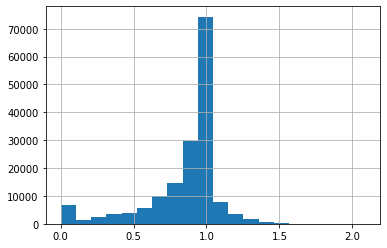

In [25]:
pred_9_implicit.top_score.hist(bins = 20);

In [26]:
pred_9_implicit.drop(columns = 'top_score', inplace = True)

In [28]:
pred_9_implicit.columns = [int(c) for c in pred_9_implicit.columns]

In [29]:
pred_9_implicit

,0,1,2,3,4,5,6,7,8,9
0,1572239.0,1194894.0,1762210.0,1856280.0,1522471.0,685656.0,1251142.0,1941262.0,1714175.0,1300048.0
1,943786.0,849692.0,788705.0,264277.0,139941.0,80018.0,495680.0,2079951.0,831243.0,1204002.0
4,1398419.0,472415.0,1288917.0,1249588.0,1570747.0,212696.0,1315647.0,139363.0,1904536.0,49679.0
5,1950320.0,1412311.0,553430.0,417142.0,2012901.0,6328.0,74407.0,139969.0,1425483.0,1503864.0
6,684728.0,1246530.0,1203834.0,1668054.0,392957.0,232562.0,1725528.0,1651120.0,1480574.0,773952.0
...,...,...,...,...,...,...,...,...,...,...
177032,1303554.0,641327.0,212469.0,38857.0,153972.0,1800653.0,652921.0,1438163.0,1662703.0,836208.0
177043,1068648.0,1380223.0,211696.0,137522.0,210245.0,1294510.0,107802.0,1306245.0,711862.0,1945320.0
177052,467427.0,1114800.0,115596.0,1946789.0,2020215.0,2032781.0,2074404.0,1902728.0,975089.0,2075982.0
177057,1329161.0,1360112.0,346969.0,1450837.0,1303928.0,1986828.0,821446.0,1095197.0,1559667.0,2055370.0


In [30]:
implicit_index = set(pred_9_implicit.index)

In [31]:
len(implicit_index & search_index)

619

In [32]:
implicit_search_intersection = list(implicit_index & search_index)

In [33]:
search_recs = search_recs.loc[search_recs.index.difference(implicit_search_intersection)]

In [34]:
search_recs

,0,1,2,3,4,5,6,7,8,9
3,814644,1892910,1929037,337033,976976,1495252,541684,448188,816584,1380283
7,1082150,1383352,228294,280001,905962,906435,520318,830606,1501646,63665
14,1851419,148757,1220316,1182308,1274709,511711,311980,2029715,635704,1005775
90,109814,1169893,218698,1885984,1540766,512315,916762,502870,84712,1726133
98,1429023,655663,174389,1589919,1147203,1332181,1231500,1760346,1313508,1476421
...,...,...,...,...,...,...,...,...,...,...
177022,829923,1793967,485717,1692963,760768,1685125,1030062,1487578,1311781,925639
177024,131921,90072,423989,791587,1042837,736983,1816259,1603854,630862,1478801
177028,34681,1638469,1313392,154859,656288,371714,1230747,774374,547697,763433
177037,245362,1541195,260797,852531,1473056,195149,2045233,1624469,634569,1091661


In [35]:
pred_9_implicit_with_zeroview_search = pd.concat([pred_9_implicit, search_recs])

In [36]:
pred_9_implicit_with_zeroview_search.sort_index(inplace = True)

In [37]:
pred_9_implicit_with_zeroview_search

,0,1,2,3,4,5,6,7,8,9
0,1572239.0,1194894.0,1762210.0,1856280.0,1522471.0,685656.0,1251142.0,1941262.0,1714175.0,1300048.0
1,943786.0,849692.0,788705.0,264277.0,139941.0,80018.0,495680.0,2079951.0,831243.0,1204002.0
2,1986443.0,167018.0,283306.0,1425647.0,1362449.0,1614538.0,1219935.0,1660615.0,991246.0,539599.0
3,814644.0,1892910.0,1929037.0,337033.0,976976.0,1495252.0,541684.0,448188.0,816584.0,1380283.0
4,1398419.0,472415.0,1288917.0,1249588.0,1570747.0,212696.0,1315647.0,139363.0,1904536.0,49679.0
...,...,...,...,...,...,...,...,...,...,...
177065,263806.0,874462.0,2079562.0,816728.0,1034016.0,303475.0,699092.0,1263012.0,1135051.0,1452141.0
177066,1651522.0,1763050.0,1183025.0,765481.0,524786.0,331472.0,1191685.0,1384867.0,1907343.0,1190780.0
177067,273237.0,1174434.0,2033823.0,1480530.0,556280.0,1295465.0,1426798.0,1550304.0,391625.0,1812717.0
177068,1803169.0,273725.0,662857.0,517435.0,1116998.0,1396359.0,1663098.0,1565340.0,807614.0,998923.0


In [38]:
pred_9_implicit_with_zeroview_search = pred_9_implicit_with_zeroview_search.astype(int)

In [39]:
pred_9_implicit_with_zeroview_search

,0,1,2,3,4,5,6,7,8,9
0,1572239,1194894,1762210,1856280,1522471,685656,1251142,1941262,1714175,1300048
1,943786,849692,788705,264277,139941,80018,495680,2079951,831243,1204002
2,1986443,167018,283306,1425647,1362449,1614538,1219935,1660615,991246,539599
3,814644,1892910,1929037,337033,976976,1495252,541684,448188,816584,1380283
4,1398419,472415,1288917,1249588,1570747,212696,1315647,139363,1904536,49679
...,...,...,...,...,...,...,...,...,...,...
177065,263806,874462,2079562,816728,1034016,303475,699092,1263012,1135051,1452141
177066,1651522,1763050,1183025,765481,524786,331472,1191685,1384867,1907343,1190780
177067,273237,1174434,2033823,1480530,556280,1295465,1426798,1550304,391625,1812717
177068,1803169,273725,662857,517435,1116998,1396359,1663098,1565340,807614,998923


In [40]:
pred_9_fn = 'pred_9_implicit_with_zeroview_search.csv'
pred_9_fp = os.path.join(reports_dir, pred_9_fn)
pred_9_implicit_with_zeroview_search.to_csv(pred_9_fp, header = None, index = None)

# pred 10

In [77]:
pt_search_recs_fn = 'pt_search_recs.pkl'
pt_search_recs_fp = os.path.join(interim_data_dir, pt_search_recs_fn)
pt_search_recs = pd.read_pickle(pt_search_recs_fp)

es_search_recs_fn = 'es_search_recs.pkl'
es_search_recs_fp = os.path.join(interim_data_dir, es_search_recs_fn)
es_search_recs = pd.read_pickle(es_search_recs_fp)

In [78]:
pt_search_recs = pt_search_recs.applymap(lambda x: x[0]).T
es_search_recs = es_search_recs.applymap(lambda x: x[0]).T

In [79]:
pt_search_recs['origin'] = 's_pt'
es_search_recs['origin'] = 's_es'

In [80]:
pt_search_index = set(pt_search_recs.index)
es_search_index = set(es_search_recs.index)

In [81]:
pt_search_index & es_search_index

set()

In [82]:
search_recs = pd.concat([pt_search_recs, es_search_recs])

In [83]:
search_index = set(search_recs.index)

In [84]:
search_recs.columns

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'origin'], dtype='object')

In [85]:
pt_pred_10_fn = 'pt' + '_for_pred_10_implicit_gcp.csv'
pt_pred_10_fp = os.path.join(reports_dir, pt_pred_10_fn)
pt_pred_10 = pd.read_csv(pt_pred_10_fp, index_col = 0)

es_pred_10_fn = 'es' + '_for_pred_10_implicit_gcp.csv'
es_pred_10_fp = os.path.join(reports_dir, es_pred_10_fn)
es_pred_10 = pd.read_csv(es_pred_10_fp, index_col = 0)

In [86]:
pt_pred_10['origin'] = 'pt'
es_pred_10['origin'] = 'es'

In [87]:
# juntar a partir daqui....

In [88]:
pt_index = set(pt_pred_10.index)
es_index = set(es_pred_10.index)

In [89]:
pt_index & es_index

set()

In [90]:
pred_10_implicit = pd.concat([pt_pred_10, es_pred_10])

In [91]:
pred_10_implicit

,0,1,2,3,4,5,6,7,8,9,top_score,origin
0,1572239.0,1194894.0,1856280.0,398330.0,1628496.0,1717880.0,1300048.0,1658036.0,12511.0,678444.0,0.950889,pt
1,943786.0,849692.0,788705.0,1180937.0,139941.0,80018.0,1676401.0,264277.0,495680.0,549607.0,0.996541,pt
4,1398419.0,642144.0,98360.0,377950.0,441078.0,301332.0,1810302.0,1758821.0,2030989.0,1147418.0,0.665280,pt
5,1950320.0,1412311.0,553430.0,1094798.0,417142.0,758537.0,2012901.0,1673649.0,139969.0,6328.0,0.966146,pt
6,684728.0,1246530.0,1203834.0,1668054.0,1725528.0,232562.0,1651120.0,1465623.0,392957.0,1480574.0,0.976229,pt
...,...,...,...,...,...,...,...,...,...,...,...,...
177032,1303554.0,641327.0,212469.0,38857.0,153972.0,1800653.0,1438163.0,657619.0,1662703.0,1764954.0,0.984379,es
177043,1380223.0,1068648.0,137522.0,210245.0,211696.0,107802.0,1470915.0,1306245.0,1497163.0,711862.0,0.837588,es
177052,467427.0,1114800.0,115596.0,1946789.0,2020215.0,1234857.0,2074404.0,2075982.0,1902728.0,83909.0,0.964847,es
177057,1329161.0,1732254.0,40965.0,987982.0,633283.0,1416141.0,912678.0,2055370.0,660578.0,821446.0,0.558798,es


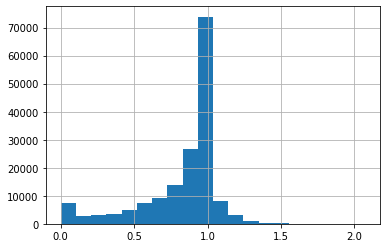

In [92]:
pred_10_implicit.top_score.hist(bins = 20);

In [93]:
# pred_9_implicit.drop(columns = 'top_score', inplace = True)

In [94]:
pred_10_implicit.columns = [int(c) if c.isnumeric() else c for c in pred_10_implicit.columns]

In [95]:
pred_10_implicit

,0,1,2,3,4,5,6,7,8,9,top_score,origin
0,1572239.0,1194894.0,1856280.0,398330.0,1628496.0,1717880.0,1300048.0,1658036.0,12511.0,678444.0,0.950889,pt
1,943786.0,849692.0,788705.0,1180937.0,139941.0,80018.0,1676401.0,264277.0,495680.0,549607.0,0.996541,pt
4,1398419.0,642144.0,98360.0,377950.0,441078.0,301332.0,1810302.0,1758821.0,2030989.0,1147418.0,0.665280,pt
5,1950320.0,1412311.0,553430.0,1094798.0,417142.0,758537.0,2012901.0,1673649.0,139969.0,6328.0,0.966146,pt
6,684728.0,1246530.0,1203834.0,1668054.0,1725528.0,232562.0,1651120.0,1465623.0,392957.0,1480574.0,0.976229,pt
...,...,...,...,...,...,...,...,...,...,...,...,...
177032,1303554.0,641327.0,212469.0,38857.0,153972.0,1800653.0,1438163.0,657619.0,1662703.0,1764954.0,0.984379,es
177043,1380223.0,1068648.0,137522.0,210245.0,211696.0,107802.0,1470915.0,1306245.0,1497163.0,711862.0,0.837588,es
177052,467427.0,1114800.0,115596.0,1946789.0,2020215.0,1234857.0,2074404.0,2075982.0,1902728.0,83909.0,0.964847,es
177057,1329161.0,1732254.0,40965.0,987982.0,633283.0,1416141.0,912678.0,2055370.0,660578.0,821446.0,0.558798,es


In [96]:
implicit_index = set(pred_10_implicit.index)

In [97]:
len(implicit_index & search_index)

619

In [98]:
implicit_search_intersection = list(implicit_index & search_index)

In [99]:
search_recs = search_recs.loc[search_recs.index.difference(implicit_search_intersection)]

In [100]:
search_recs

,0,1,2,3,4,5,6,7,8,9,origin
3,814644,1892910,1929037,337033,976976,1495252,541684,448188,816584,1380283,s_pt
7,1082150,1383352,228294,280001,905962,906435,520318,830606,1501646,63665,s_pt
14,1851419,148757,1220316,1182308,1274709,511711,311980,2029715,635704,1005775,s_pt
90,109814,1169893,218698,1885984,1540766,512315,916762,502870,84712,1726133,s_pt
98,1429023,655663,174389,1589919,1147203,1332181,1231500,1760346,1313508,1476421,s_pt
...,...,...,...,...,...,...,...,...,...,...,...
177022,829923,1793967,485717,1692963,760768,1685125,1030062,1487578,1311781,925639,s_pt
177024,131921,90072,423989,791587,1042837,736983,1816259,1603854,630862,1478801,s_pt
177028,34681,1638469,1313392,154859,656288,371714,1230747,774374,547697,763433,s_pt
177037,245362,1541195,260797,852531,1473056,195149,2045233,1624469,634569,1091661,s_pt


In [101]:
pred_10_implicit_with_zeroview_search = pd.concat([pred_10_implicit, search_recs])

In [102]:
pred_10_implicit_with_zeroview_search.sort_index(inplace = True)

In [103]:
pred_10_implicit_with_zeroview_search

,0,1,2,3,4,5,6,7,8,9,top_score,origin
0,1572239.0,1194894.0,1856280.0,398330.0,1628496.0,1717880.0,1300048.0,1658036.0,12511.0,678444.0,0.950889,pt
1,943786.0,849692.0,788705.0,1180937.0,139941.0,80018.0,1676401.0,264277.0,495680.0,549607.0,0.996541,pt
2,1986443.0,167018.0,283306.0,1614538.0,1425647.0,539599.0,991246.0,1362449.0,1660615.0,1219935.0,0.998528,es
3,814644.0,1892910.0,1929037.0,337033.0,976976.0,1495252.0,541684.0,448188.0,816584.0,1380283.0,NaN,s_pt
4,1398419.0,642144.0,98360.0,377950.0,441078.0,301332.0,1810302.0,1758821.0,2030989.0,1147418.0,0.665280,pt
...,...,...,...,...,...,...,...,...,...,...,...,...
177065,151949.0,922608.0,1576765.0,1920855.0,1578171.0,1738141.0,695509.0,751492.0,1528880.0,90662.0,0.000626,pt
177066,1651522.0,1384867.0,331472.0,1763050.0,765481.0,1183025.0,1191685.0,524786.0,1907343.0,1190780.0,0.957724,es
177067,1426798.0,273237.0,1550304.0,2033823.0,1839331.0,1174434.0,289602.0,136713.0,1576126.0,1395589.0,1.197726,pt
177068,1803169.0,273725.0,1116998.0,517435.0,662857.0,1396359.0,1663098.0,1565340.0,998923.0,807614.0,0.392717,pt


In [104]:
pred_10_interim_fn = 'pred_10_interim.pkl'
pred_10_interim_fp = os.path.join(interim_data_dir, pred_10_interim_fn)
pred_10_implicit_with_zeroview_search.to_pickle(pred_10_interim_fp)

In [105]:
pred_10_implicit_with_zeroview_search.drop(['top_score', 'origin'], axis = 1, inplace = True)

In [106]:
pred_10_implicit_with_zeroview_search = pred_10_implicit_with_zeroview_search.astype(int)

In [107]:
pred_10_implicit_with_zeroview_search

,0,1,2,3,4,5,6,7,8,9
0,1572239,1194894,1856280,398330,1628496,1717880,1300048,1658036,12511,678444
1,943786,849692,788705,1180937,139941,80018,1676401,264277,495680,549607
2,1986443,167018,283306,1614538,1425647,539599,991246,1362449,1660615,1219935
3,814644,1892910,1929037,337033,976976,1495252,541684,448188,816584,1380283
4,1398419,642144,98360,377950,441078,301332,1810302,1758821,2030989,1147418
...,...,...,...,...,...,...,...,...,...,...
177065,151949,922608,1576765,1920855,1578171,1738141,695509,751492,1528880,90662
177066,1651522,1384867,331472,1763050,765481,1183025,1191685,524786,1907343,1190780
177067,1426798,273237,1550304,2033823,1839331,1174434,289602,136713,1576126,1395589
177068,1803169,273725,1116998,517435,662857,1396359,1663098,1565340,998923,807614


In [108]:
pred_10_fn = 'pred_10_implicit_with_zeroview_search.csv'
pred_10_fp = os.path.join(reports_dir, pred_10_fn)
pred_10_implicit_with_zeroview_search.to_csv(pred_10_fp, header = None, index = None)

In [110]:
pred_10_implicit_with_zeroview_search

,0,1,2,3,4,5,6,7,8,9
0,1572239,1194894,1856280,398330,1628496,1717880,1300048,1658036,12511,678444
1,943786,849692,788705,1180937,139941,80018,1676401,264277,495680,549607
2,1986443,167018,283306,1614538,1425647,539599,991246,1362449,1660615,1219935
3,814644,1892910,1929037,337033,976976,1495252,541684,448188,816584,1380283
4,1398419,642144,98360,377950,441078,301332,1810302,1758821,2030989,1147418
...,...,...,...,...,...,...,...,...,...,...
177065,151949,922608,1576765,1920855,1578171,1738141,695509,751492,1528880,90662
177066,1651522,1384867,331472,1763050,765481,1183025,1191685,524786,1907343,1190780
177067,1426798,273237,1550304,2033823,1839331,1174434,289602,136713,1576126,1395589
177068,1803169,273725,1116998,517435,662857,1396359,1663098,1565340,998923,807614


# pred 11

In [119]:
pt_search_recs_fn = 'pt_search_recs.pkl'
pt_search_recs_fp = os.path.join(interim_data_dir, pt_search_recs_fn)
pt_search_recs = pd.read_pickle(pt_search_recs_fp)

es_search_recs_fn = 'es_search_recs.pkl'
es_search_recs_fp = os.path.join(interim_data_dir, es_search_recs_fn)
es_search_recs = pd.read_pickle(es_search_recs_fp)

In [120]:
pt_search_recs = pt_search_recs.applymap(lambda x: x[0]).T
es_search_recs = es_search_recs.applymap(lambda x: x[0]).T

In [121]:
pt_search_recs['origin'] = 's_pt'
es_search_recs['origin'] = 's_es'

In [122]:
pt_search_index = set(pt_search_recs.index)
es_search_index = set(es_search_recs.index)

In [123]:
pt_search_index & es_search_index

set()

In [124]:
search_recs = pd.concat([pt_search_recs, es_search_recs])

In [125]:
search_index = set(search_recs.index)

In [126]:
search_recs.columns

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'origin'], dtype='object')

In [127]:
pt_pred_11_fn = 'pt' + '_for_pred_11_implicit_gcp.csv'
pt_pred_11_fp = os.path.join(reports_dir, pt_pred_11_fn)
pt_pred_11 = pd.read_csv(pt_pred_11_fp, index_col = 0)

es_pred_11_fn = 'es' + '_for_pred_11_implicit_gcp.csv'
es_pred_11_fp = os.path.join(reports_dir, es_pred_11_fn)
es_pred_11 = pd.read_csv(es_pred_11_fp, index_col = 0)

In [128]:
pt_pred_11['origin'] = 'pt'
es_pred_11['origin'] = 'es'

In [129]:
# juntar a partir daqui....

In [130]:
pt_index = set(pt_pred_11.index)
es_index = set(es_pred_11.index)

In [131]:
pt_index & es_index

set()

In [132]:
pred_11_implicit = pd.concat([pt_pred_11, es_pred_11])

In [133]:
pred_11_implicit

,0,1,2,3,4,5,6,7,8,9,top_score,origin
0,1572239.0,1194894.0,1717880.0,1300048.0,1006988.0,398330.0,1326593.0,341077.0,1856280.0,762780.0,0.933297,pt
1,943786.0,849692.0,495680.0,1676401.0,1056120.0,937449.0,416551.0,1180937.0,80018.0,1184491.0,0.986264,pt
4,1398419.0,174968.0,1063140.0,963863.0,764932.0,1730990.0,377950.0,1587422.0,1889311.0,243325.0,0.466541,pt
5,1950320.0,553430.0,1412311.0,758537.0,769817.0,1094798.0,74407.0,1605669.0,236682.0,1756706.0,0.950465,pt
6,684728.0,1246530.0,392957.0,1668054.0,1465623.0,1203834.0,927771.0,1651120.0,416584.0,1725528.0,0.926044,pt
...,...,...,...,...,...,...,...,...,...,...,...,...
177032,1303554.0,641327.0,212469.0,38857.0,153972.0,1800653.0,1438163.0,1182879.0,356985.0,1206877.0,0.976482,es
177043,1380223.0,1068648.0,210245.0,211696.0,137522.0,107802.0,711862.0,1497163.0,1945320.0,2101548.0,0.717872,es
177052,467427.0,1114800.0,1946789.0,2020215.0,2074404.0,1740917.0,115596.0,2075982.0,1234857.0,83909.0,0.929420,es
177057,1329161.0,153499.0,40965.0,1095197.0,1559667.0,1732254.0,821446.0,912678.0,1416141.0,1450837.0,0.317113,es


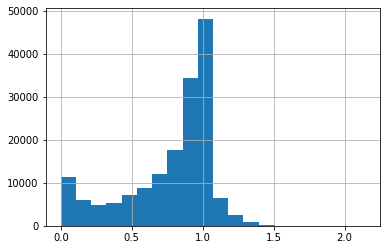

In [134]:
pred_11_implicit.top_score.hist(bins = 20);

In [135]:
# pred_9_implicit.drop(columns = 'top_score', inplace = True)

In [136]:
pred_11_implicit.columns = [int(c) if c.isnumeric() else c for c in pred_11_implicit.columns]

In [137]:
pred_11_implicit

,0,1,2,3,4,5,6,7,8,9,top_score,origin
0,1572239.0,1194894.0,1717880.0,1300048.0,1006988.0,398330.0,1326593.0,341077.0,1856280.0,762780.0,0.933297,pt
1,943786.0,849692.0,495680.0,1676401.0,1056120.0,937449.0,416551.0,1180937.0,80018.0,1184491.0,0.986264,pt
4,1398419.0,174968.0,1063140.0,963863.0,764932.0,1730990.0,377950.0,1587422.0,1889311.0,243325.0,0.466541,pt
5,1950320.0,553430.0,1412311.0,758537.0,769817.0,1094798.0,74407.0,1605669.0,236682.0,1756706.0,0.950465,pt
6,684728.0,1246530.0,392957.0,1668054.0,1465623.0,1203834.0,927771.0,1651120.0,416584.0,1725528.0,0.926044,pt
...,...,...,...,...,...,...,...,...,...,...,...,...
177032,1303554.0,641327.0,212469.0,38857.0,153972.0,1800653.0,1438163.0,1182879.0,356985.0,1206877.0,0.976482,es
177043,1380223.0,1068648.0,210245.0,211696.0,137522.0,107802.0,711862.0,1497163.0,1945320.0,2101548.0,0.717872,es
177052,467427.0,1114800.0,1946789.0,2020215.0,2074404.0,1740917.0,115596.0,2075982.0,1234857.0,83909.0,0.929420,es
177057,1329161.0,153499.0,40965.0,1095197.0,1559667.0,1732254.0,821446.0,912678.0,1416141.0,1450837.0,0.317113,es


In [138]:
implicit_index = set(pred_11_implicit.index)

In [139]:
len(implicit_index & search_index)

619

In [140]:
implicit_search_intersection = list(implicit_index & search_index)

In [141]:
search_recs = search_recs.loc[search_recs.index.difference(implicit_search_intersection)]

In [142]:
search_recs

,0,1,2,3,4,5,6,7,8,9,origin
3,814644,1892910,1929037,337033,976976,1495252,541684,448188,816584,1380283,s_pt
7,1082150,1383352,228294,280001,905962,906435,520318,830606,1501646,63665,s_pt
14,1851419,148757,1220316,1182308,1274709,511711,311980,2029715,635704,1005775,s_pt
90,109814,1169893,218698,1885984,1540766,512315,916762,502870,84712,1726133,s_pt
98,1429023,655663,174389,1589919,1147203,1332181,1231500,1760346,1313508,1476421,s_pt
...,...,...,...,...,...,...,...,...,...,...,...
177022,829923,1793967,485717,1692963,760768,1685125,1030062,1487578,1311781,925639,s_pt
177024,131921,90072,423989,791587,1042837,736983,1816259,1603854,630862,1478801,s_pt
177028,34681,1638469,1313392,154859,656288,371714,1230747,774374,547697,763433,s_pt
177037,245362,1541195,260797,852531,1473056,195149,2045233,1624469,634569,1091661,s_pt


In [143]:
pred_11_implicit_with_zeroview_search = pd.concat([pred_11_implicit, search_recs])

In [144]:
pred_11_implicit_with_zeroview_search.sort_index(inplace = True)

In [145]:
pred_11_implicit_with_zeroview_search

,0,1,2,3,4,5,6,7,8,9,top_score,origin
0,1572239.0,1194894.0,1717880.0,1300048.0,1006988.0,398330.0,1326593.0,341077.0,1856280.0,762780.0,0.933297,pt
1,943786.0,849692.0,495680.0,1676401.0,1056120.0,937449.0,416551.0,1180937.0,80018.0,1184491.0,0.986264,pt
2,1986443.0,167018.0,283306.0,731397.0,1614538.0,539599.0,1362449.0,1660615.0,991246.0,1219935.0,0.975139,es
3,814644.0,1892910.0,1929037.0,337033.0,976976.0,1495252.0,541684.0,448188.0,816584.0,1380283.0,NaN,s_pt
4,1398419.0,174968.0,1063140.0,963863.0,764932.0,1730990.0,377950.0,1587422.0,1889311.0,243325.0,0.466541,pt
...,...,...,...,...,...,...,...,...,...,...,...,...
177065,931029.0,1411362.0,1737819.0,590144.0,1453777.0,913345.0,1690694.0,1737605.0,1174197.0,1329094.0,0.000239,pt
177066,1651522.0,1907343.0,524786.0,1183025.0,331472.0,1191685.0,765481.0,1384867.0,1763050.0,1190780.0,0.921649,es
177067,1426798.0,273237.0,1550304.0,2033823.0,1395589.0,1480530.0,289602.0,136713.0,1576126.0,460028.0,1.064152,pt
177068,1116998.0,517435.0,273725.0,1197876.0,1396359.0,1803169.0,662857.0,453931.0,1565340.0,1054230.0,0.247183,pt


In [146]:
pred_11_interim_fn = 'pred_11_interim.pkl'
pred_11_interim_fp = os.path.join(interim_data_dir, pred_11_interim_fn)
pred_11_implicit_with_zeroview_search.to_pickle(pred_11_interim_fp)

In [147]:
pred_11_implicit_with_zeroview_search.drop(['top_score', 'origin'], axis = 1, inplace = True)

In [148]:
pred_11_implicit_with_zeroview_search = pred_11_implicit_with_zeroview_search.astype(int)

In [149]:
pred_11_implicit_with_zeroview_search

,0,1,2,3,4,5,6,7,8,9
0,1572239,1194894,1717880,1300048,1006988,398330,1326593,341077,1856280,762780
1,943786,849692,495680,1676401,1056120,937449,416551,1180937,80018,1184491
2,1986443,167018,283306,731397,1614538,539599,1362449,1660615,991246,1219935
3,814644,1892910,1929037,337033,976976,1495252,541684,448188,816584,1380283
4,1398419,174968,1063140,963863,764932,1730990,377950,1587422,1889311,243325
...,...,...,...,...,...,...,...,...,...,...
177065,931029,1411362,1737819,590144,1453777,913345,1690694,1737605,1174197,1329094
177066,1651522,1907343,524786,1183025,331472,1191685,765481,1384867,1763050,1190780
177067,1426798,273237,1550304,2033823,1395589,1480530,289602,136713,1576126,460028
177068,1116998,517435,273725,1197876,1396359,1803169,662857,453931,1565340,1054230


In [150]:
pred_11_fn = 'pred_11_implicit_with_zeroview_search.csv'
pred_11_fp = os.path.join(reports_dir, pred_11_fn)
pred_11_implicit_with_zeroview_search.to_csv(pred_11_fp, header = None, index = None)

In [151]:
pred_11_implicit_with_zeroview_search

,0,1,2,3,4,5,6,7,8,9
0,1572239,1194894,1717880,1300048,1006988,398330,1326593,341077,1856280,762780
1,943786,849692,495680,1676401,1056120,937449,416551,1180937,80018,1184491
2,1986443,167018,283306,731397,1614538,539599,1362449,1660615,991246,1219935
3,814644,1892910,1929037,337033,976976,1495252,541684,448188,816584,1380283
4,1398419,174968,1063140,963863,764932,1730990,377950,1587422,1889311,243325
...,...,...,...,...,...,...,...,...,...,...
177065,931029,1411362,1737819,590144,1453777,913345,1690694,1737605,1174197,1329094
177066,1651522,1907343,524786,1183025,331472,1191685,765481,1384867,1763050,1190780
177067,1426798,273237,1550304,2033823,1395589,1480530,289602,136713,1576126,460028
177068,1116998,517435,273725,1197876,1396359,1803169,662857,453931,1565340,1054230
